<a href="https://colab.research.google.com/github/easleydp/AIAE-to-SPX-total-returns/blob/main/AIAE_to_SPX_total_returns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aggregate (or Average) Investor Allocation to Equities (AIAE)

This notebook uses the most recently available data to plot the AIAE valuation measure introduced by Jesse Livermore in his Dec 2013 essay ["The Single Greatest Predictor of Future Stock Market Returns"](https://www.philosophicaleconomics.com/2013/12/the-single-greatest-predictor-of-future-stock-market-returns/). AIAE is calculated using freely available data from [FRED (Federal Reserve Economic Data program)](https://fred.stlouisfed.org/docs/api/fred/fred.html). Livermore showed how the AIAE ratio on any given date is predictive of [SPX](https://en.wikipedia.org/wiki/S%26P_500) total returns over the subsequent 10 years.

Raymond Micaletti's research note "[Market Timing Using Aggregate Equity Allocation Signals](https://alphaarchitect.com/2021/04/29/market-timing-using-aggregate-equity-allocation-signals/)" re-visited the analysis in Apr 2021. He found that AIAE continues to trump all the well-known indicators (such as CAPE ratio) and concluded: "While rarely mentioned in discussions of equity forecasting indicators, the AIAE does appear to be the single greatest predictor of long-term equity returns currently in the public domain."

---
NOTE: Delete the `data` folder to have the FRED CSV files downloaded afresh, otherwise the existing files will be used (the source data is only updated quarterly). Alternatively (since manually deleting a folder in Google Colab is a bit of a chore), temporarily set `force_refresh` to `True` in the next code block.

In [39]:
# Download the FRED data

# As an alternative to deleting the `data` folder, temporarily set this
# to True for force a refresh of the CSV files.
force_refresh = False

# Each of these data frames has a DATE series and $ value series. The latter is
# in billions unless `'millions':true`, in which case we'll transform the values
# to billions.
fred_frames = [
    # Nonfinancial Corporate Business; Corporate Equities; Liability, Market Value Levels
    {'id':"NCBCEL"},
    # Domestic Financial Sectors; Corporate Equities; Liability, Level
    {'id':"FBCELLQ027S", 'millions':True},
    # State and Local Governments; Debt Securities and Loans; Liability, Level
    {'id':"SLGTCMDODNS"},
    # Households and Nonprofit Organizations​; Debt Securities and Loans; Liability, Level
    {'id':"TCMILBSHNO"},
    # Nonfinancial Corporate Business; Debt Securities and Loans; Liability, Level
    {'id':"TCMILBSNNCB"},
    # Federal Government; Debt Securities and Loans; Liability, Level
    {'id':"FGTCMDODNS"},
    # Rest of the World; Debt Securities and Loans; Liability, Level
    {'id':"WCMITCMFODNS"}
]

# We'll also fetch recession data so we can paint grey bars in the background
# of the plot. This frame has a DATE series and a flag series (0 and 1).
recession_id = 'JHDUSRGDPBR'  # Dates of U.S. recessions as inferred by GDP-based recession indicator


from pathlib import Path
import urllib.request

data_dir = Path('data')
if force_refresh or not data_dir.exists():
    print('Refreshing CSV files...')
    data_dir.mkdir(exist_ok=True)
    start_year = 1989  # Min supported is 1952

    def request_csv(id, start_year):
        url = f'https://fred.stlouisfed.org/graph/fredgraph.csv?cosd={start_year}-01-01&id={id}'
        urllib.request.urlretrieve(url, f'data/{id}.csv')
    for ff in fred_frames:
        request_csv(ff['id'], start_year)
    request_csv(recession_id, max(start_year, 1968)) # FRED recession data is only available since 1968

    print('\tCSV files refereshed.')
else:
    print('Using existing CSV files.')



Using existing CSV files.


In [40]:
# Process the FRED data and calculate AIAE

import pandas as pd
from dateutil.relativedelta import relativedelta

# The timestamps of the FRED data are at the beginning of the quarter to
# which they correspond, but the values are as of the end of the quarter.
# So we shift the FRED timestamps to the end of the quarter.
def shift_timestamps(frame):
    values = frame['DATE']
    values.update(values.transform(lambda d: d + relativedelta(months=3)))

def read_csv(id):
    return pd.read_csv(f'data/{id}.csv', header=0, parse_dates=['DATE'])

last_fred_frame = None
for ff in fred_frames:
    id = ff['id']
    dataframe = read_csv(id)
    ff['dataframe'] = dataframe

    shift_timestamps(dataframe)

    # Convert Value to billions if necessary
    if ff.get('millions', False):
        values = dataframe[ff['id']]
        values.update(values.transform(lambda v: v / 1000))

    # Confirm all dataframes have the same Date series
    if not last_fred_frame is None:
        if not last_fred_frame['dataframe']['DATE'].equals(dataframe['DATE']):
            sys.exit(f'Date series differ between {last_fred_frame["id"]} and {id}!')
    last_fred_frame = ff

# Likewise, the recession data (odd one out because it has its own length and values are flags)
recession_frame = read_csv(recession_id)
shift_timestamps(recession_frame)

# Transform frames so that DATE is the index. (This is primarily for the
# sake of the $ value frames, as a preliminary step before merging.)
def make_date_the_index(frame):
    frame.set_index('DATE', inplace=True, verify_integrity=True)
for ff in fred_frames:
    make_date_the_index(ff['dataframe'])
make_date_the_index(recession_frame)

# Merge the $ value frames into a new frame that includes a computed "AIAE" series.
# (We then drop the other series from the new frame.)
def compute_aiae_frame():
    frames = [ff['dataframe'] for ff in fred_frames]
    frame = pd.concat(frames, axis=1)
    # Compute a new "AIAE" series
    frame['AIAE'] = (frame['NCBCEL']+frame['FBCELLQ027S']) / \
      (frame['NCBCEL']+frame['FBCELLQ027S'] + \
       (frame['SLGTCMDODNS']+frame['TCMILBSHNO']+frame['TCMILBSNNCB']+frame['FGTCMDODNS']+frame['WCMITCMFODNS']))
    frame.drop(columns=[ff['id'] for ff in fred_frames], inplace=True)
    return frame

aiae_frame = compute_aiae_frame()
aiae_series = aiae_frame["AIAE"]
first_date = aiae_series.index[0]
last_date = aiae_series.index[-1]
date_format = "%Y-%m-%d"
print(f'{aiae_series.size} quarters ({first_date.strftime(date_format)} to {last_date.strftime(date_format)})')

129 quarters (1989-04-01 to 2021-04-01)


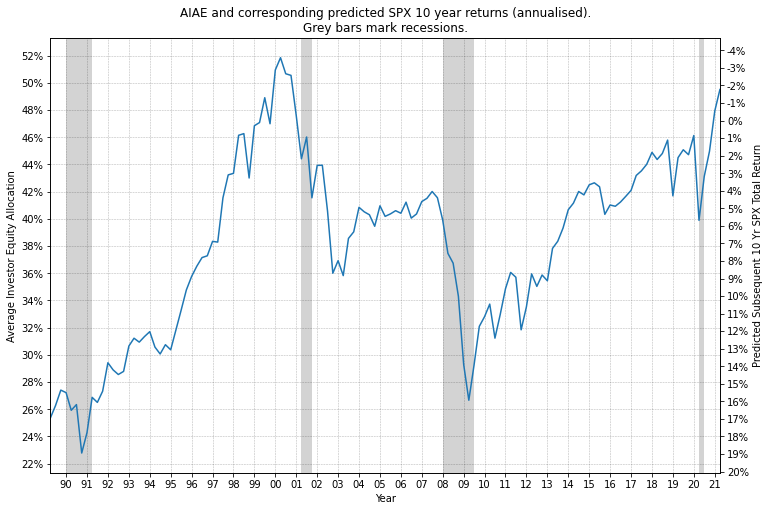

In [59]:
# Plot AIAE, correlated with SPX 10yr returns

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick

fig, ax_aiae = plt.subplots(figsize=(12, 8)) # size in inches
ax_spx = ax_aiae.twinx() # Create a twin y-axis sharing the x-axis


# The approach used for keeping the two y-axes properly correlated is taken
# from Matplotlib's tech note "Different scales on the same axes":
# <https://matplotlib.org/stable/gallery/subplots_axes_and_figures/fahrenheit_celsius_scales.html>

# Formula for predicted SPX 10 year total return given AIAE.
#   The equation derived from this scatter chart
#     https://i2.wp.com/www.philosophicaleconomics.com/wp-content/uploads/2013/12/linearavg1.jpg
#       is: spx returns = 0.335 - 0.678 * aiae
#   Oddly, the AIAE / SPX correlation depicted in the essay's main chart is noticably different:
#     https://i0.wp.com/www.philosophicaleconomics.com/wp-content/uploads/2013/12/avginv11.jpg
spx_from_aiae = lambda aiae: 0.366 - 0.775 * aiae

# Closure function to be used as a callback
def update_spx_axis_according_to_aiae_axis(ax_aiae):
    y1, y2 = ax_aiae.get_ylim()
    ax_spx.set_ylim(spx_from_aiae(y1), spx_from_aiae(y2))
    ax_spx.figure.canvas.draw()

# Automatically update ylim of ax_spx when ylim of ax_aiae changes
ax_aiae.callbacks.connect("ylim_changed", update_spx_axis_according_to_aiae_axis)
ax_aiae.plot(aiae_frame)


# x-axis ticks for each year
ax_aiae.xaxis.set_major_locator(mdates.YearLocator())
ax_aiae.xaxis.set_major_formatter(mdates.DateFormatter("%y"))

# Format y-axes as percent
ax_aiae.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, 0))
ax_spx.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, 0))

# Control frequency of y-axis ticks (every 2% for AIAE and 1% for SPX)
ax_aiae.yaxis.set_major_locator(mtick.MultipleLocator(0.02))
ax_spx.yaxis.set_major_locator(mtick.MultipleLocator(0.01))

# Ensure plot line is tight against the y-axes
ax_aiae.margins(x=0)
# ... and the recession bars are tight against the top and bottom
ax_aiae.axis('tight')

# Include grid lines
ax_aiae.grid(color='black', alpha=0.3, linestyle='dashed', linewidth=0.5)

# Paint grey bars in the background of the plot to indicate recessions
def determine_recession_spans():
    # Returns list of list[dt, dt], each inner list being the span of a recession.
    spans = []
    current_span = None
    for index, row in recession_frame.iterrows():
        if row[recession_id] == 1:
            if current_span is None:
                current_span = [index, index]
                spans.append(current_span)
            else:
                current_span[-1] = index
        else:
            current_span = None
    return spans
interpolate_date = lambda dt: (dt - first_date) / (last_date - first_date)
# Maps list of `[date, date]` to list of `(interpolated date, interpolated date)`,
# where `interpolated date` is a value betweeen 0.0 and 1.0 covering the x-axis.
interpolate_dates = lambda date_spans: \
    map(lambda span: 
        (interpolate_date(span[0]), interpolate_date(span[1])), date_spans)
ymin, ymax = ax_aiae.get_ylim()
for span in interpolate_dates(determine_recession_spans()):
    ax_aiae.axhspan(ymin, ymax, span[0], span[1], facecolor='lightgrey')

# Title and axis labels
ax_aiae.set_title('AIAE and corresponding predicted SPX 10 year returns (annualised).\nGrey bars mark recessions.')
ax_aiae.set_ylabel('Average Investor Equity Allocation')
ax_spx.set_ylabel('Predicted Subsequent 10 Yr SPX Total Return')
ax_aiae.set_xlabel("Year")

plt.show()
